Import all needed libraries and functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import math
import sys, os
import time
sys.path.append(os.path.abspath("..")) 

from scipy.fftpack import dctn, idctn

def additive_noise(phase, sigma, enabled=True):
    if enabled:
        noise = np.random.normal(0, sigma, size=phase.shape)
        return phase + noise
    return phase

In [3]:
# Optics
lam   = 0.532     # wavelength (µm)

 For the case of a cylinder perpindicular to the z axis 

In [5]:
from src.cylinder_phase import cylinder_phase_perp_to_z_3d

# Grid (µm/px)
Nx, Ny = 512, 512
px, py = 0.2, 0.2

# Material: either a scalar, a 2D array n(x,y), or a callable n_obj(X,Y,z)
n_obj = 1.38      # medium for cylinder
n_med = 1.33      # medium index
pz    = 0.2       # z step for integration (µm)   

# Activate for cylinder geometry

R = 20        # radius (µm)
L = 70.0          # axis length along x (µm); set None for infinite

phi_true, phi_wrapped, tissue_mask, medium_mask  = cylinder_phase_perp_to_z_3d(
    Nx, Ny, px, py,
    R, L,
    lam=lam, n_med=n_med,
    n_obj=n_obj,
    pz=pz
)

phi_wrapped_used = phi_wrapped

Optionally add noise (currently white noise)

In [6]:
# Choose wether to use random noisy data or not and choose how noisy it will be 
use_noisy = True
sigma = 0.4 # How noisy will the data be

# Choose wether to apply correction to the background
apply_correction = True 

plots = [phi_true, phi_wrapped_used]
plots_names = ["Ground Truth Phase (rad)", "Wrapped Phase (rad)"]
n = 2

if use_noisy:
    phi_noisy = additive_noise(phi_true, sigma, enabled=True)
    phi_wrapped_used = additive_noise(phi_wrapped, sigma, enabled=True)
else:
    phi_noisy = None
    phi_wrapped_used = phi_wrapped


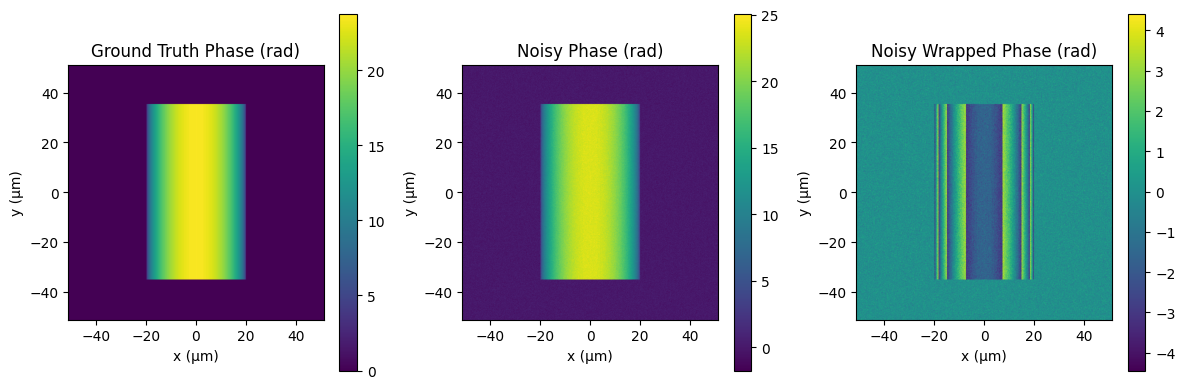

In [7]:
# Build plots list
plots = [phi_true, phi_wrapped_used]
plots_names = ["Ground Truth Phase (rad)", 
               "Noisy Wrapped Phase (rad)" if use_noisy else "Wrapped Phase (rad)"]

if use_noisy:
    plots.insert(1, phi_noisy)
    plots_names.insert(1, "Noisy Phase (rad)")

n = len(plots)

# Plot

fig, axes = plt.subplots(1, n, figsize=(12,4))

for i, (data, name) in enumerate(zip(plots, plots_names)):
    im = axes[i].imshow(data, origin='lower',
                        extent=[-Nx*px/2, Nx*px/2, -Ny*py/2, Ny*py/2])
    axes[i].set_title(name)
    plt.colorbar(im, ax=axes[i])
    axes[i].set_xlabel("x (µm)")
    axes[i].set_ylabel("y (µm)")

plt.tight_layout()

np.unwrap

unwraps by adding/ substracting 2pi whenever there's a jump larger than pi.
https://numpy.org/doc/2.3/reference/generated/numpy.unwrap.html

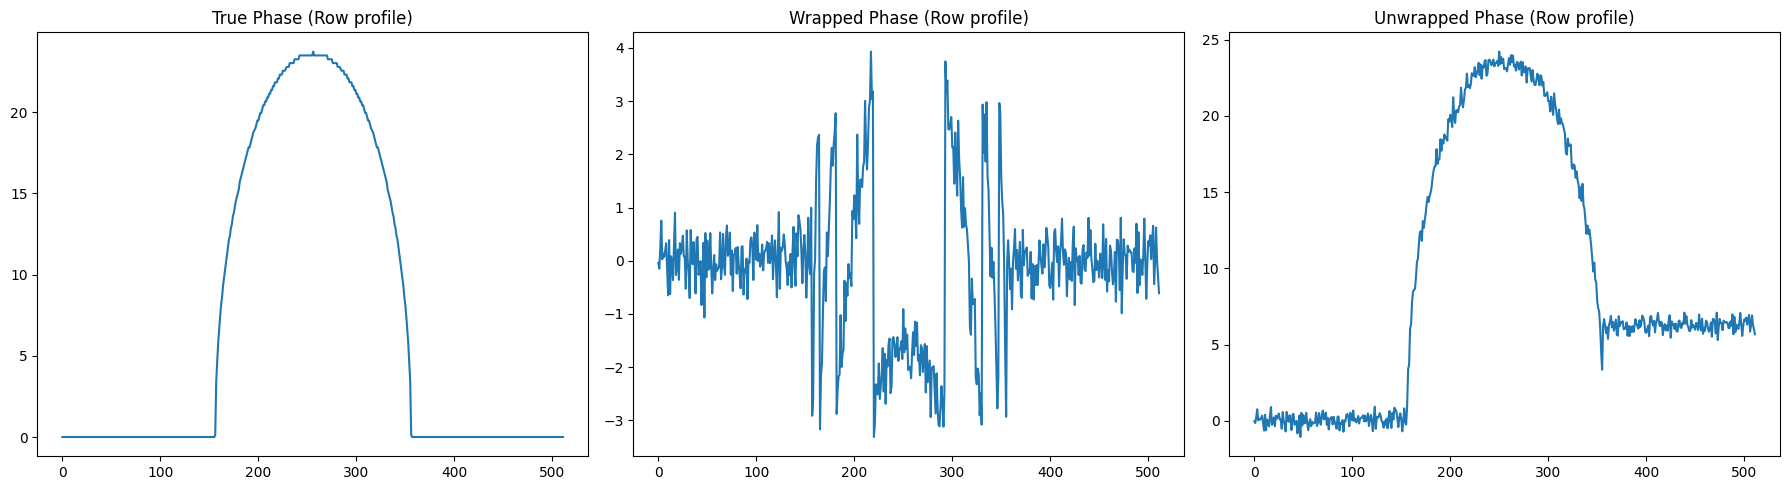

In [12]:
row_idx = 100  # pick any row index
row_profile_true = phi_true[row_idx, :]
row_profile_wrapped = phi_wrapped_used[row_idx, :]
row_profile_unwrapped = np.unwrap(phi_wrapped_used[row_idx, :])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(row_profile_true)
axes[0].set_title("True Phase (Row profile)")

axes[1].plot(row_profile_wrapped)
axes[1].set_title("Wrapped Phase (Row profile)")

axes[2].plot(row_profile_unwrapped)
axes[2].set_title("Unwrapped Phase (Row profile)")

plt.tight_layout()
plt.show()

Sorting by reliability following a noncontinuous path 

The algorithm sorts pixels by how reliable they are and then solves a path integral

Miguel Arevallilo Herráez, David R. Burton, Michael J. Lalor, and Munther A. Gdeisat, "Fast two-dimensional phase-unwrapping algorithm based on sorting by reliability following a noncontinuous path," Appl. Opt. 41, 7437-7444 (2002)

rms error: 1.9385768905695824
Execution time: 0.08183097839355469 seconds


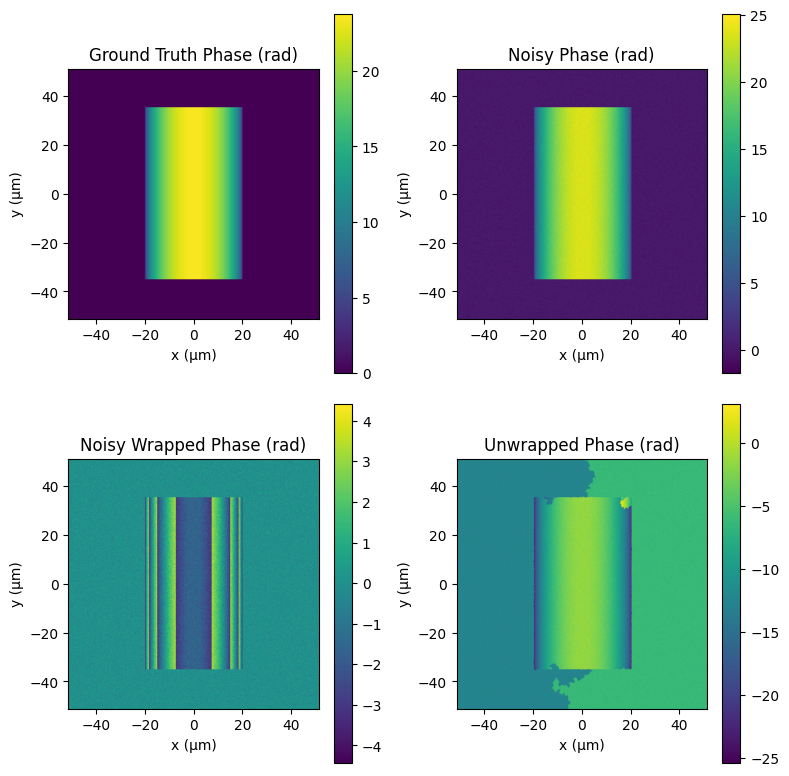

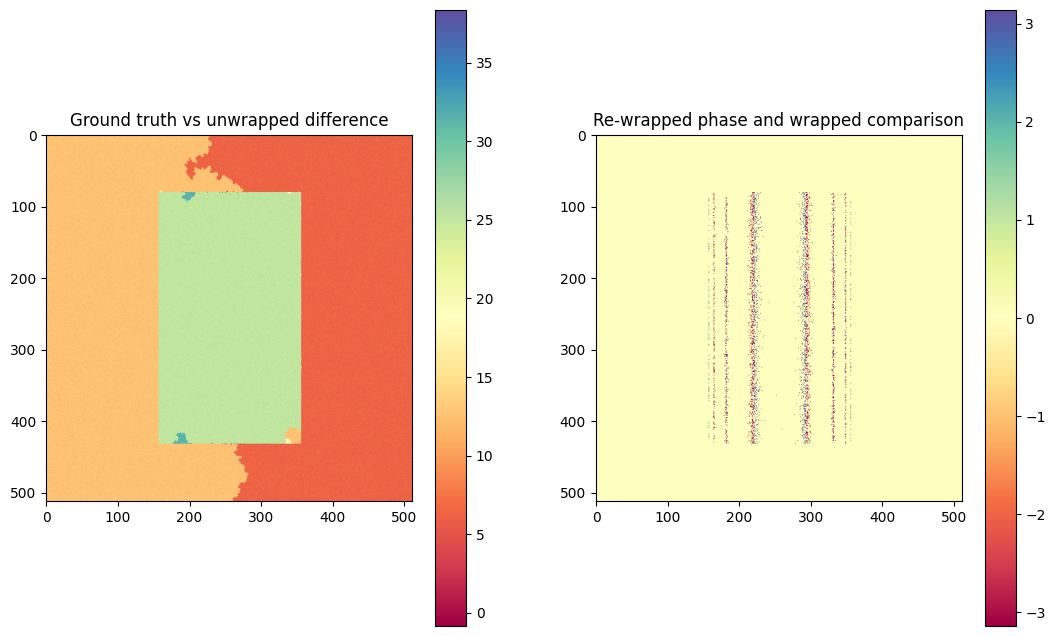

In [13]:
from skimage.restoration import unwrap_phase
from sklearn.metrics import root_mean_squared_error
from src.rmse import evaluate_phase

# unwrap
start = time.time()         # record start time
phi_unwrapped = unwrap_phase(phi_wrapped_used)
end = time.time()           # record end time

# Plot
plots.append(phi_unwrapped)
plots_names.append("Unwrapped Phase (rad)")

n = len(plots)

cols = math.ceil(math.sqrt(n))   # columns
rows = math.ceil(n / cols)       # rows

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.ravel()  # flatten to 1D for easy looping

for i, (data, name) in enumerate(zip(plots, plots_names)):
    im = axes[i].imshow(data, origin='lower',
                        extent=[-Nx*px/2, Nx*px/2, -Ny*py/2, Ny*py/2])
    axes[i].set_title(name)
    plt.colorbar(im, ax=axes[i])
    axes[i].set_xlabel("x (µm)")
    axes[i].set_ylabel("y (µm)")

# hide empty subplots if grid > n
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()

plots = [phi_true, phi_wrapped_used]

truth_unwrapped_comp = phi_true - phi_unwrapped

rewrapped = phi_rewrapped = np.angle(np.exp(1j * phi_unwrapped))

rewrapped_wrapped_comp = rewrapped - phi_wrapped_used

fig, axes = plt.subplots(1, 2, figsize=(13, 8))

im0 = axes[0].imshow(truth_unwrapped_comp, cmap='Spectral')
axes[0].set_title("Ground truth vs unwrapped difference")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(rewrapped_wrapped_comp, cmap='Spectral', vmin=-np.pi, vmax=np.pi)
axes[1].set_title("Re-wrapped phase and wrapped comparison")
plt.colorbar(im1, ax=axes[1])

rms = evaluate_phase(phi_true, phi_unwrapped, tissue_mask)
print("rms error:", rms)
print("Execution time:", end - start, "seconds")

Perform 2D phase unwrapping using the weighted least-squares method 
described by Ghiglia and Romero (1994), using DCT-based Poisson solvers. If weighted uses picard iteration

   Ghiglia, D. C., & Romero, L. A. (1994). 
    "Robust two-dimensional weighted and unweighted phase unwrapping that uses 
    fast transforms and iterative methods." JOSA A, 11(1), 107–117.
    https://doi.org/10.1364/JOSAA.11.000107

    https://github.com/Zeekk9/GhiliaUnwap?tab=readme-ov-file

For the weighted option, I used the algorithm from before (sorting by reliability), and added a mask and smoothing of the weights in the borders


Unweighted rms error: 1.5399593158746385
Weighted rms error: 5.42818960452404
Weighted + Mask rms error: 0.594668421705059


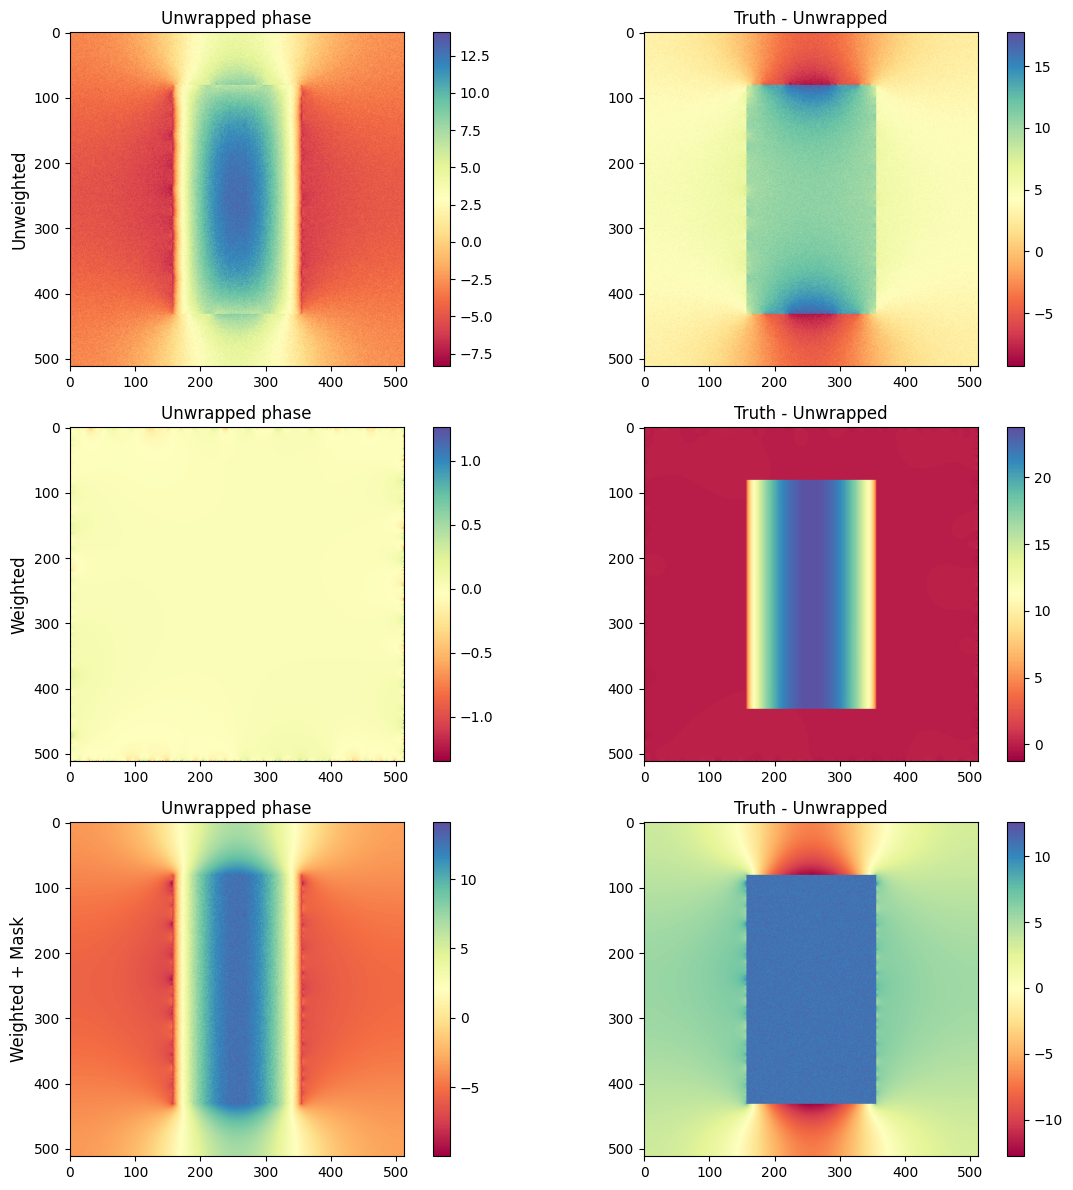

Execution time: 2.261301279067993 seconds


In [16]:
from src.Ghilia.Ghilia import unwrap_phase_weighted
from src.Ghilia.reliability import reliability_weight_map
from scipy.ndimage import gaussian_filter

start = time.time()
weights = reliability_weight_map(phi_wrapped_used)
weights_masked = weights * tissue_mask
W_smooth = gaussian_filter(weights_masked, sigma=1.0)  

phi_unwrapped_ghilia = unwrap_phase_weighted(phi_wrapped_used)
phi_unwrapped_ghilia_weighted = unwrap_phase_weighted(phi_wrapped_used,weights)
phi_unwrapped_ghilia_weighted_masked = unwrap_phase_weighted(phi_wrapped_used,weights_masked)
#phi_unwrapped_ghilia_weighted_masked_smooth = unwrap_phase_weighted(phi_wrapped_used,W_smooth)
end = time.time()

# Plot
plots = [phi_unwrapped_ghilia,
         phi_unwrapped_ghilia_weighted,
         phi_unwrapped_ghilia_weighted_masked]

names = ["Unweighted", "Weighted", "Weighted + Mask"]  # now 3 names

n = len(plots)
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))

for i, (phi_unwrapped, name) in enumerate(zip(plots, names)):
    comp = phi_true - phi_unwrapped

    im1 = axes[i, 0].imshow(phi_unwrapped, cmap="Spectral")
    axes[i, 0].set_title("Unwrapped phase")
    plt.colorbar(im1, ax=axes[i, 0])

    im2 = axes[i, 1].imshow(comp, cmap='Spectral')
    axes[i, 1].set_title("Truth - Unwrapped")
    plt.colorbar(im2, ax=axes[i, 1])

    axes[i, 0].set_ylabel(name, fontsize=12)

    rms = evaluate_phase(phi_true, phi_unwrapped, tissue_mask)
    print(f"{name} rms error: {rms}")

plt.tight_layout()
plt.show()

print("Execution time:", end - start, "seconds")

Arm based on this paper:

https://www-spiedigitallibrary-org.tudelft.idm.oclc.org/journals/optical-engineering/volume-57/issue-04/043113/Comparison-of-multihardware-parallel-implementations-for-a-phase-unwrapping-algorithm/10.1117/1.OE.57.4.043113.full

Works also on LS but adds mechanism to minimize impact of residues
with this source:

https://codeocean.com/capsule/2672585/tree/v1

* insert credits
* explenation on implemetation of C code

Still need to insrt some weights based on the paper, to improve results


In [18]:
from src.ARM.unwrap_arm import unwrap_phase_ARM
if use_noisy:
    plots.insert(1, phi_noisy)
    plots_names.insert(1, "Noisy Phase (rad)")

phi_unwrapped = unwrap_phase_ARM(phi_wrapped_used)
print(phi_unwrapped.shape)

plots.append(phi_unwrapped)
plots_names.append("Unwrapped Phase (rad)")
n = len(plots)


# Plot
"""

cols = math.ceil(math.sqrt(n))   # columns
rows = math.ceil(n / cols)       # rows
"""

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.ravel()  # flatten to 1D for easy looping

for i, (data, name) in enumerate(zip(plots, plots_names)):
    im = axes[i].imshow(data, origin='lower',
                        extent=[-Nx*px/2, Nx*px/2, -Ny*py/2, Ny*py/2])
    axes[i].set_title(name)
    plt.colorbar(im, ax=axes[i])
    axes[i].set_xlabel("x (µm)")
    axes[i].set_ylabel("y (µm)")

# hide empty subplots if grid > n
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()

plots = [phi_true, phi_wrapped_used]

OSError: /home/oheymans/odt-thesis/src/ARM/arm.dll: invalid ELF header

Network Programming based -  Phase differences of neighboring pixels can be estimated with a potential error that is an integer multiple
of 2pi. This suggests the formulation of the phase unwrapping problem as a global minimization problem with integer variables. The phase
unwrapping problem can be equated to the problem of finding the minimum cost flow on a network.

M. Costantini, "A novel phase unwrapping method based on network programming," in IEEE Transactions on Geoscience and Remote Sensing, vol. 36, no. 3, pp. 813-821, May 1998, doi: 10.1109/36.673674.
https://ieeexplore-ieee-org.tudelft.idm.oclc.org/document/673674

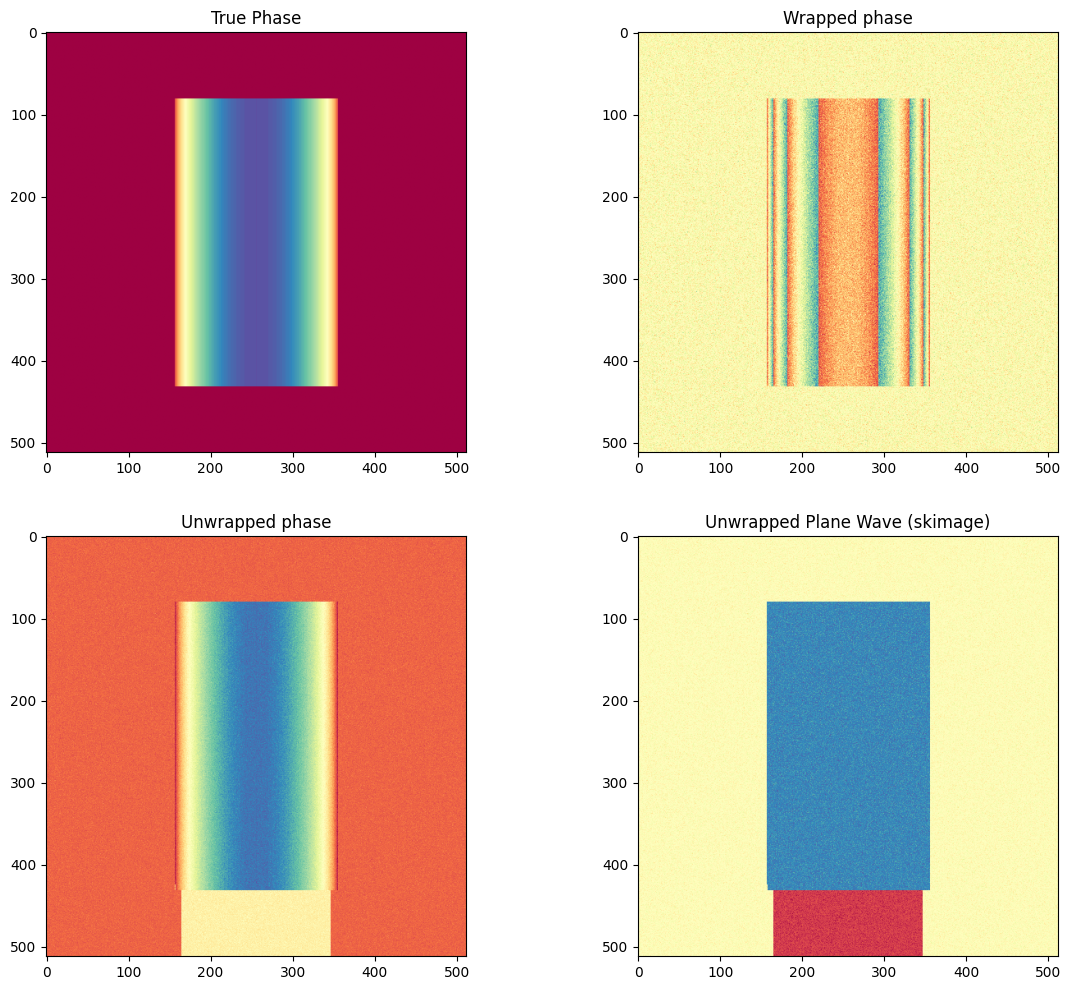

Execution time: 138.18906593322754 seconds


In [ ]:
from kamui import unwrap_dimensional

CMAP = 'Spectral'

start = time.time()
result = unwrap_dimensional(phi_wrapped_used)
end = time.time()

fig = plt.figure(figsize=(14, 12))
plt.subplot(221)
plt.title('True Phase')
plt.imshow(phi_true, cmap=CMAP)
plt.subplot(222)
plt.title('Wrapped phase')
plt.imshow(wrapped_plane_wave, cmap=CMAP)
plt.subplot(223)
plt.title('Unwrapped phase')
plt.imshow(result, cmap=CMAP)
plt.subplot(224)
plt.title('Unwrapped to true phase comparison')
plt.imshow(phi_true - result, cmap=CMAP)
plt.show()

print("Execution time:", end - start, "seconds")

In [2]:
from kamui import unwrap_dimensional

start = time.time()
phi_unwrapped_puma = unwrap_dimensional(
    phi_wrapped_used,
    merging_method="gc"   # "gc" = graph-cut (PUMA)
)
end = time.time()

fig = plt.figure(figsize=(14, 12))
plt.subplot(221)
plt.title('True Phase')
plt.imshow(phi_true, cmap=CMAP)
plt.subplot(222)
plt.title('Wrapped phase')
plt.imshow(phi_wrapped_used, cmap=CMAP)
plt.subplot(223)
plt.title('Unwrapped phase')
plt.imshow(phi_unwrapped_puma, cmap=CMAP)
plt.subplot(224)
plt.title('comparison')
plt.imshow(phi_true - phi_unwrapped_puma, cmap=CMAP)
plt.show()

print("Execution time:", end - start, "seconds")

ModuleNotFoundError: No module named 'kamui'

Parallel Goldstein 
https://www.sciencedirect.com/science/article/pii/S0143816619306566?via%3Dihub



In [ ]:
from src.Goldstein import unwrap_goldstein
phi_unwrapped = unwrap_phase_qgpu(phi_wrapped_used)

plots.append(phi_unwrapped)
plots_names.append("Unwrapped Phase (rad)")
n = len(plots)


fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.ravel()  # flatten to 1D for easy looping

for i, (data, name) in enumerate(zip(plots, plots_names)):
    im = axes[i].imshow(data, origin='lower',
                        extent=[-Nx*px/2, Nx*px/2, -Ny*py/2, Ny*py/2])
    axes[i].set_title(name)
    plt.colorbar(im, ax=axes[i])
    axes[i].set_xlabel("x (µm)")
    axes[i].set_ylabel("y (µm)")

# hide empty subplots if grid > n
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()

plots = [phi_true, phi_wrapped_used]